In [1]:
import sys
sys.path.append('src')

In [2]:
import pandas
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.scenario import Scenario
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve

Scales

In [3]:
scales=TemporalScale(discretization_list=[1]) 

Resources

In [4]:
Biomass= Resource(name='Biomass', price=36.11, cons_max= 10**10, basis='GJ', label='Biomass') #table 2

GridPower = Resource(name='GridPower', cons_max = 10**10, price=9.72, basis='GJ', label='Grid Electricity')

NG = Resource(name='NG', price= 8.89, cons_max= 10*10, basis='GJ', label='Natural gas')
Power=Resource(name='Power', basis='kW',label='Electrical Power')
Heat=Resource(name='Heat', basis='kW',label='Heat Power')

CO2_Vent = Resource(name='CO2_Vent', sell=True, basis='tons', label='Carbon dioxide')

Solar = Resource(name = 'Solar', cons_max=10**10, basis ='GJ', label ='Solar energy') 
Wind = Resource(name = 'Wind', cons_max=10**10, basis ='GJ', label ='Wind energy')

Lighting = Resource(name='Lighting', demand=True, basis='kW',label='Lighting')
Refrigeration = Resource(name='Refrigeration', demand=True, basis='kW',label='Refrigeration') 
Heating = Resource(name='Heating', demand=True, basis='kW',label='Heating')


Processes

In [6]:
ST= Process(name='BM_ST', conversion={Biomass: -1, Power: 277.78*0.68, CO2_Vent:100},capex=250, fopex=15,
            cap_min=100, cap_max=1000000, label='Biomass ST', basis='PJ') #table 3 


CHP= Process(name='NG_CHP', conversion={NG: -1, Power: 277.78*0.44, CO2_Vent: 56, Heat: 277.78*0.28},
             capex=500, fopex=15, cap_max=1000000, cap_min=800, label='Natural Gas CHP', basis='PJ')


PV= Process(name='PV', conversion={Solar: -1, Power: 277.78*0.09}, capex=2000, fopex = 500, 
             cap_max=300, cap_min=10, label='Solar PV',  basis='kW')


WF= Process(name='WF',conversion={Wind: -1, Power: 277.78*0.22}, capex=2000, fopex=1200,
             cap_max=500, cap_min=10, label='Wind Farm', basis='kW') 


Grid = Process(name = 'Grid', conversion = {GridPower:-1, Power:277.78, CO2_Vent:90}, 
               basis = 'PJ', label = 'Grid Electricity', cap_max = 1000)

In [8]:
Refrigerator = Process(name = 'Refrigerator', conversion = {Power:-1, Refrigeration:1*3}, capex = 70, vopex = 4, 
             basis = 'kW', label = 'Refrigerator', cap_max = 1000)

LED = Process(name = 'LED', conversion = {Power:-1, Lighting:1*0.8}, capex = 10, vopex = 1, 
             basis = 'kW', label = 'LED', cap_max = 1000)

Heater = Process(name = 'Heater', conversion = {Heat:-1, Heating:1*0.85}, capex = 30, vopex = 3, 
             basis = 'kW', label = 'Heater', cap_max = 1000)

Location

In [9]:
place = Location(name = 'place', processes = {ST, CHP, PV, WF, Grid, Refrigerator, LED, Heater}, 
                 scales = scales, label = 'College Station')

Scenario

In [10]:
scenario= Scenario(name='scenario', network=place, 
                   demand= {place:{Heating:100, Lighting:200, Refrigeration:1000}},
                   network_scale_level=0,scheduling_scale_level=0, scales=scales, label='scenario', demand_scale_level = 0)
#26000 is the total power we will need in 20 years running the supermarket


In [11]:
scenario.demand

{place: {Heating: 100, Lighting: 200, Refrigeration: 1000}}

Plotting

In [12]:
lp=formulate(scenario=scenario, constraints=
            {
            Constraints.COST,
            Constraints.PRODUCTION,
            Constraints.RESOURCE_BALANCE,
            Constraints.INVENTORY,
            Constraints.NETWORK,
            Constraints.DEMAND,
            }, objective=Objective.COST)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost


In [13]:
lp.constraint_demand.pprint()

constraint_demand : specific demand for resources
    Size=3, Index=constraint_demand_index, Active=True
    Key                           : Lower  : Body                     : Upper : Active
          ('place', 'Heating', 0) :  100.0 :       S[place,Heating,0] :  +Inf :   True
         ('place', 'Lighting', 0) :  200.0 :      S[place,Lighting,0] :  +Inf :   True
    ('place', 'Refrigeration', 0) : 1000.0 : S[place,Refrigeration,0] :  +Inf :   True


In [14]:
results=solve(scenario= scenario, instance=lp, solver='gurobi', name='lp')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 150 rows, 145 columns and 294 nonzeros
Model fingerprint: 0x3d97f526
Variable types: 137 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [8e-01, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 143 rows and 137 columns
Presolve time: 0.00s
Presolved: 7 rows, 8 columns, 16 nonzeros
Variable types: 6 continuous, 2 integer (2 binary)
Found heuristic solution: objective 443326.40934

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution

In [15]:
results.output['Cap_P'] #CAPACITY PRODUCED 

{('place', 'BM_ST', 0): 0.0,
 ('place', 'Grid', 0): 1000.0,
 ('place', 'Heater', 0): 117.64705882352916,
 ('place', 'LED', 0): 250.0,
 ('place', 'NG_CHP', 0): 800.0,
 ('place', 'PV', 0): 0.0,
 ('place', 'Refrigerator', 0): 333.3333333333333,
 ('place', 'WF', 0): 0.0}

In [16]:
results.output['S'] #AMOUNT SOLD / DEMAND 

{('place', 'Heating', 0): 100.00000000000001,
 ('place', 'Refrigeration', 0): 1000.0,
 ('place', 'Lighting', 0): 200.0,
 ('place', 'CO2_Vent', 0): 213.80501224897768}

In [17]:
results.output['P'] #Amount Produced

{('place', 'Refrigerator', 0): 333.3333333333333,
 ('place', 'PV', 0): 0.0,
 ('place', 'LED', 0): 250.0,
 ('place', 'WF', 0): 0.0,
 ('place', 'BM_ST', 0): 0.0,
 ('place', 'Grid', 0): 1.4344423059741573,
 ('place', 'NG_CHP', 0): 1.5125929412732766,
 ('place', 'Heater', 0): 117.64705882352942}

In [18]:
results.output['C'] #Amount Consumed 

{('place', 'NG', 0): 1.5125929412732766,
 ('place', 'Biomass', 0): 0.0,
 ('place', 'GridPower', 0): 1.4344423059741573,
 ('place', 'Solar', 0): 0.0,
 ('place', 'Wind', 0): 0.0}

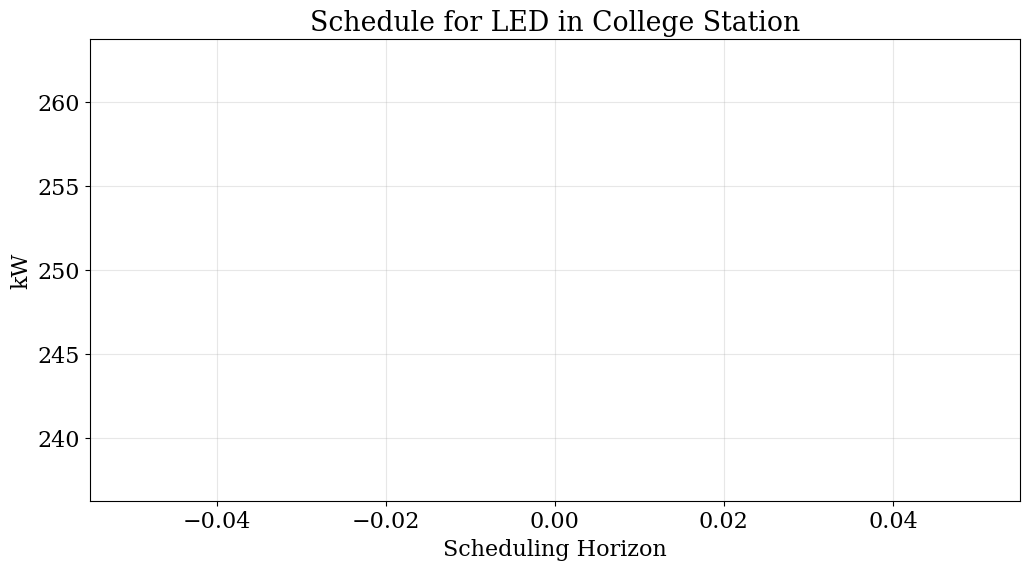

In [20]:
plot_results.schedule(results=results, y_axis='P', component='LED',location='place')